### Time Series Analysis & Sales Insights of Coffee Products (2024)

In [1]:
# Load the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

In [3]:
df=pd.read_csv("coffee_index.csv");
df.head(10)

,date,time,cash_type,card,money,coffee_name
0,3/1/2024,15:50.5,card,ANON-0000-0000-0001,38.7,Latte
1,3/1/2024,19:22.5,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,3/1/2024,20:18.1,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,3/1/2024,46:33.0,card,ANON-0000-0000-0003,28.9,Americano
4,3/1/2024,48:14.6,card,ANON-0000-0000-0004,38.7,Latte
5,3/1/2024,39:47.7,card,ANON-0000-0000-0005,33.8,Americano with Milk
6,3/1/2024,19:02.8,card,ANON-0000-0000-0006,38.7,Hot Chocolate
7,3/1/2024,39:03.6,card,ANON-0000-0000-0007,33.8,Americano with Milk
8,3/1/2024,22:01.8,card,ANON-0000-0000-0008,38.7,Cocoa
9,3/1/2024,23:15.9,card,ANON-0000-0000-0008,33.8,Americano with Milk


In [4]:
print(df.dtypes)

date            object
time            object
cash_type       object
card            object
money          float64
coffee_name     object
dtype: object


In [5]:
# Convert Date to datetime type
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y', errors='coerce');
pd.to_datetime(df['date'], format='%m/%d/%y')

df['date'].head()

0   2024-03-01
1   2024-03-01
2   2024-03-01
3   2024-03-01
4   2024-03-01
Name: date, dtype: datetime64[ns]

In [6]:
# Fix times where hour > 23
def fix_time(t):
    try:
        parts = t.split(':')
        if len(parts) == 2:
            h, m = map(float, parts)
            s = 0
        elif len(parts) == 3:
            h, m, s = map(float, parts)
        else:
            return None  # skip malformed entries

        # wrap hour > 23 back into 24-hour format
        h = h % 24
        return f"{int(h):02d}:{int(m):02d}:{int(s):02d}"
    except Exception:
        return None

In [7]:
df['time'] = df['time'].astype(str).apply(fix_time);
df['time'].head()

0    15:50:00
1    19:22:00
2    20:18:00
3    22:33:00
4    00:14:00
Name: time, dtype: object

In [8]:
print(df[['date', 'time']].head())

        date      time
0 2024-03-01  15:50:00
1 2024-03-01  19:22:00
2 2024-03-01  20:18:00
3 2024-03-01  22:33:00
4 2024-03-01  00:14:00


In [9]:
# Combine and convert to datetime
# If date column is already datetime
df['datetime'] = pd.to_datetime(df['date'].dt.strftime('%Y-%m-%d') + ' ' + df['time'], errors='coerce');
df['datetime'].head() 

0   2024-03-01 15:50:00
1   2024-03-01 19:22:00
2   2024-03-01 20:18:00
3   2024-03-01 22:33:00
4   2024-03-01 00:14:00
Name: datetime, dtype: datetime64[ns]

In [10]:
df.head(15)

,date,time,cash_type,card,money,coffee_name,datetime
0,2024-03-01,15:50:00,card,ANON-0000-0000-0001,38.7,Latte,2024-03-01 15:50:00
1,2024-03-01,19:22:00,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024-03-01 19:22:00
2,2024-03-01,20:18:00,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024-03-01 20:18:00
3,2024-03-01,22:33:00,card,ANON-0000-0000-0003,28.9,Americano,2024-03-01 22:33:00
4,2024-03-01,00:14:00,card,ANON-0000-0000-0004,38.7,Latte,2024-03-01 00:14:00
5,2024-03-01,15:47:00,card,ANON-0000-0000-0005,33.8,Americano with Milk,2024-03-01 15:47:00
6,2024-03-01,19:02:00,card,ANON-0000-0000-0006,38.7,Hot Chocolate,2024-03-01 19:02:00
7,2024-03-01,15:03:00,card,ANON-0000-0000-0007,33.8,Americano with Milk,2024-03-01 15:03:00
8,2024-03-01,22:01:00,card,ANON-0000-0000-0008,38.7,Cocoa,2024-03-01 22:01:00
9,2024-03-01,23:15:00,card,ANON-0000-0000-0008,33.8,Americano with Milk,2024-03-01 23:15:00


In [11]:
df.tail()

,date,time,cash_type,card,money,coffee_name,datetime
1128,2024-07-31,05:35:00,card,ANON-0000-0000-0443,23.02,Cortado,2024-07-31 05:35:00
1129,2024-07-31,11:25:00,card,ANON-0000-0000-0040,27.92,Americano with Milk,2024-07-31 11:25:00
1130,2024-07-31,02:26:00,card,ANON-0000-0000-0444,32.82,Latte,2024-07-31 02:26:00
1131,2024-07-31,06:11:00,card,ANON-0000-0000-0445,32.82,Latte,2024-07-31 06:11:00
1132,2024-07-31,07:16:00,card,ANON-0000-0000-0446,32.82,Latte,2024-07-31 07:16:00


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1133 non-null   datetime64[ns]
 1   time         1133 non-null   object        
 2   cash_type    1133 non-null   object        
 3   card         1133 non-null   object        
 4   money        1133 non-null   float64       
 5   coffee_name  1133 non-null   object        
 6   datetime     1133 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 62.1+ KB


#### Exploratory Data Analysis of Coffee Sales

In [13]:
df.rename(columns={
    'money': 'amount',
    'coffee_name': 'product'
}, inplace=True);
df.head()

,date,time,cash_type,card,amount,product,datetime
0,2024-03-01,15:50:00,card,ANON-0000-0000-0001,38.7,Latte,2024-03-01 15:50:00
1,2024-03-01,19:22:00,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024-03-01 19:22:00
2,2024-03-01,20:18:00,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024-03-01 20:18:00
3,2024-03-01,22:33:00,card,ANON-0000-0000-0003,28.9,Americano,2024-03-01 22:33:00
4,2024-03-01,00:14:00,card,ANON-0000-0000-0004,38.7,Latte,2024-03-01 00:14:00


In [14]:
# Aggregate daily sales
daily_sales = df.groupby(df['datetime'].dt.date)['amount'].sum().reset_index();
daily_sales.columns = ['date', 'total_sales'];
daily_sales.head()

,date,total_sales
0,2024-03-01,396.3
1,2024-03-02,228.1
2,2024-03-03,349.1
3,2024-03-04,135.2
4,2024-03-05,338.5


In [15]:
print("Min datetime:", df['datetime'].min())
print("Max datetime:", df['datetime'].max())

# Optional: check if any data is truly in August
df_aug = df[df['datetime'].dt.month == 8]
print("Rows in August:", len(df_aug))

Min datetime: 2024-03-01 00:14:00
Max datetime: 2024-07-31 22:42:00
Rows in August: 0


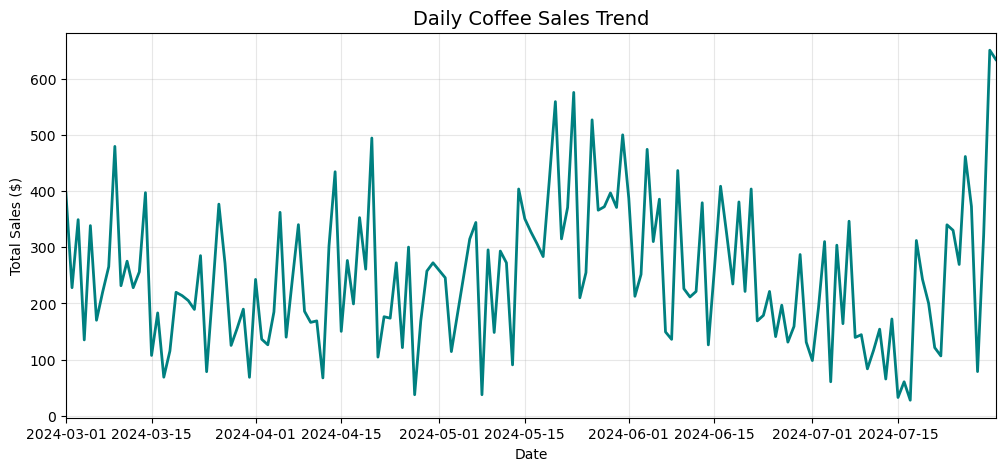

In [16]:
# Daily Coffee Sales Trend
plt.figure(figsize=(12,5))
plt.plot(daily_sales['date'], daily_sales['total_sales'], color='teal', linewidth=2)
plt.title("Daily Coffee Sales Trend", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Total Sales ($)")
plt.grid(True, alpha=0.3)
plt.xlim(pd.Timestamp('2024-03-01'), pd.Timestamp('2024-07-31'))
plt.show()

C:\Users\dell\AppData\Local\Temp\ipykernel_11148\250578397.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour', data=df, palette='cool')


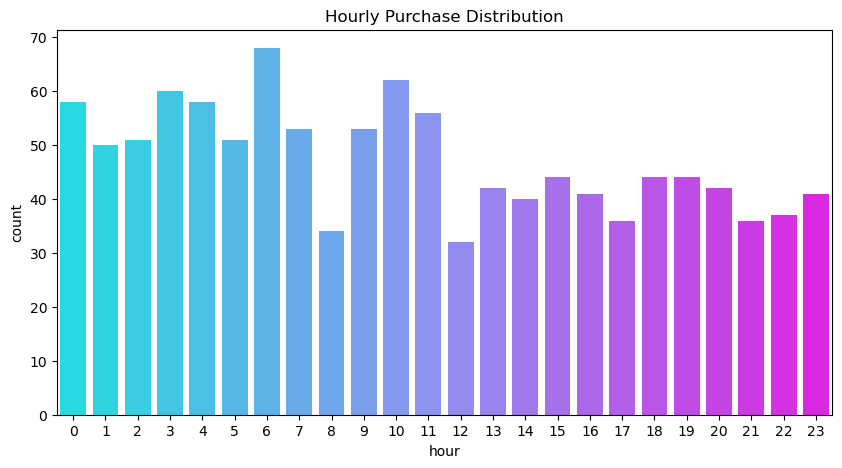

In [17]:
# Distribution of Hourly Sales
df['hour'] = df['datetime'].dt.hour
plt.figure(figsize=(10,5))
sns.countplot(x='hour', data=df, palette='cool')
plt.title("Hourly Purchase Distribution")
plt.show()

C:\Users\dell\AppData\Local\Temp\ipykernel_11148\3837163587.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='product', data=df, palette='viridis')


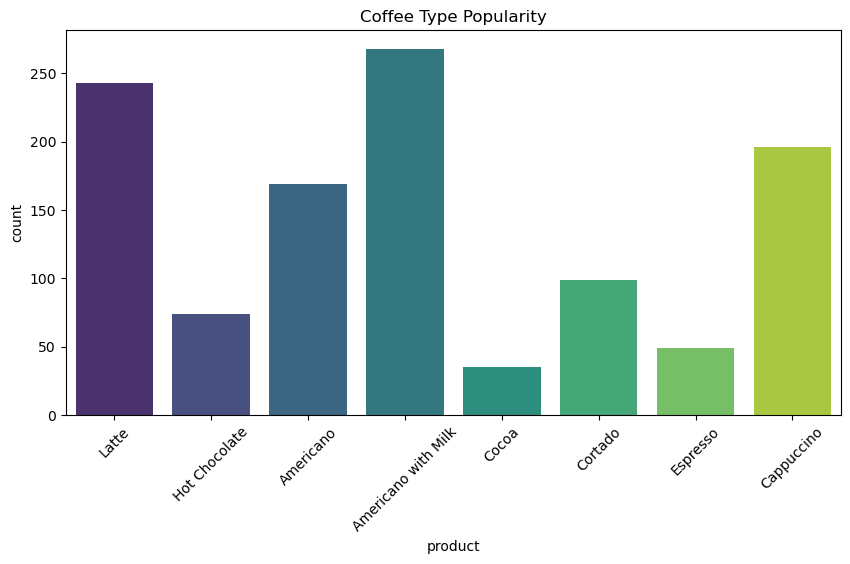

In [18]:
# Distribution of Sales of Coffee Types
plt.figure(figsize=(10,5))
sns.countplot(x='product', data=df, palette='viridis')
plt.title("Coffee Type Popularity")
plt.xticks(rotation=45)
plt.show()

In [19]:
# Extract month name and year
df['month'] = df['datetime'].dt.strftime('%b');     # e.g. 'Mar', 'Apr', etc.
df['year_month'] = df['datetime'].dt.to_period('M'); # for ordering

In [20]:
# Aggregate sales by product and month
monthly_sales = (
    df.groupby(['year_month', 'product'])['amount']
    .sum()
    .reset_index());
monthly_sales.head(10)

,year_month,product,amount
0,2024-03,Americano,1044.80
1,2024-03,Americano with Milk,1154.00
2,2024-03,Cappuccino,780.50
3,2024-03,Cocoa,232.20
4,2024-03,Cortado,869.20
5,2024-03,Espresso,241.00
6,2024-03,Hot Chocolate,854.00
7,2024-03,Latte,1874.50
8,2024-04,Americano,1001.94
9,2024-04,Americano with Milk,1407.74


In [21]:
monthly_sales = monthly_sales.sort_values('year_month');
monthly_sales.head(10)

,year_month,product,amount
0,2024-03,Americano,1044.80
1,2024-03,Americano with Milk,1154.00
2,2024-03,Cappuccino,780.50
3,2024-03,Cocoa,232.20
4,2024-03,Cortado,869.20
5,2024-03,Espresso,241.00
6,2024-03,Hot Chocolate,854.00
7,2024-03,Latte,1874.50
8,2024-04,Americano,1001.94
9,2024-04,Americano with Milk,1407.74


In [22]:
pivot_df = monthly_sales.pivot(index='year_month', columns='product', values='amount');
pivot_df

product,Americano,Americano with Milk,Cappuccino,Cocoa,Cortado,Espresso,Hot Chocolate,Latte
year_month,,,,,,,,
2024-03,1044.80,1154.00,780.50,232.20,869.20,241.00,854.00,1874.50
2024-04,1001.94,1407.74,1659.44,232.82,548.48,171.00,506.02,1193.12
2024-05,1348.80,1908.28,2078.44,340.76,474.64,185.14,529.36,2198.00
2024-06,390.88,2268.12,1735.12,189.88,530.48,230.20,528.08,1886.00
2024-07,858.12,1863.80,1079.64,300.28,322.28,273.28,361.02,1857.52


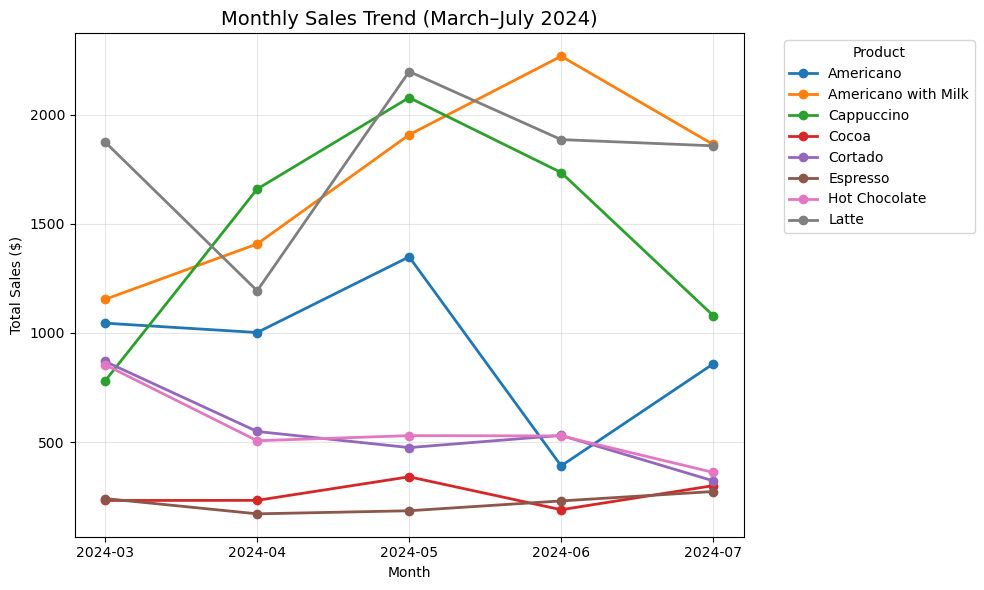

In [23]:
# LINE PLOT: Monthly Sales Trend for Each Product
plt.figure(figsize=(10,6))
for product in pivot_df.columns:
    plt.plot(pivot_df.index.astype(str), pivot_df[product], marker='o', linewidth=2, label=product)

plt.title('Monthly Sales Trend (March–July 2024)', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Total Sales ($)')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("monthly_sales_trend.png")
plt.show()

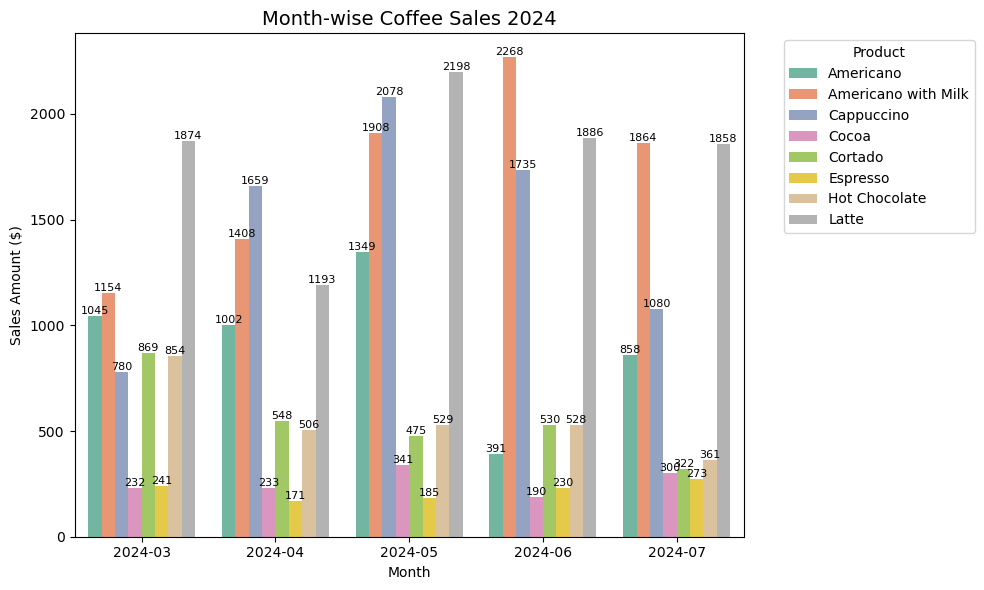

In [24]:
# BAR PLOT: Month-wise Sales by Product
plt.figure(figsize=(10,6))
ax = sns.barplot(data=monthly_sales, x=monthly_sales['year_month'].astype(str), y='amount', hue='product', palette='Set2')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=8)

plt.title('Month-wise Coffee Sales 2024', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Sales Amount ($)')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("monthly_coffee_sales.png")
plt.show()

In [25]:
df['month_name'] = df['datetime'].dt.strftime('%b');
df['month_name']

0       Mar
1       Mar
2       Mar
3       Mar
4       Mar
       ... 
1128    Jul
1129    Jul
1130    Jul
1131    Jul
1132    Jul
Name: month_name, Length: 1133, dtype: object

In [26]:
# Total sales of each product
total_sales = df.groupby('product')['amount'].sum().reset_index();
total_sales = total_sales.sort_values('amount', ascending=False);
total_sales

,product,amount
7,Latte,9009.14
1,Americano with Milk,8601.94
2,Cappuccino,7333.14
0,Americano,4644.54
6,Hot Chocolate,2778.48
4,Cortado,2745.08
3,Cocoa,1295.94
5,Espresso,1100.62


In [27]:
# Unique coffee products
products = monthly_sales['product'].unique();
n_products = len(products);
n_products

8

In [28]:
# Select a color palette with enough distinct colors
colors = sns.color_palette('tab10', n_colors=n_products);  # or 'Set2', 'Paired', etc.

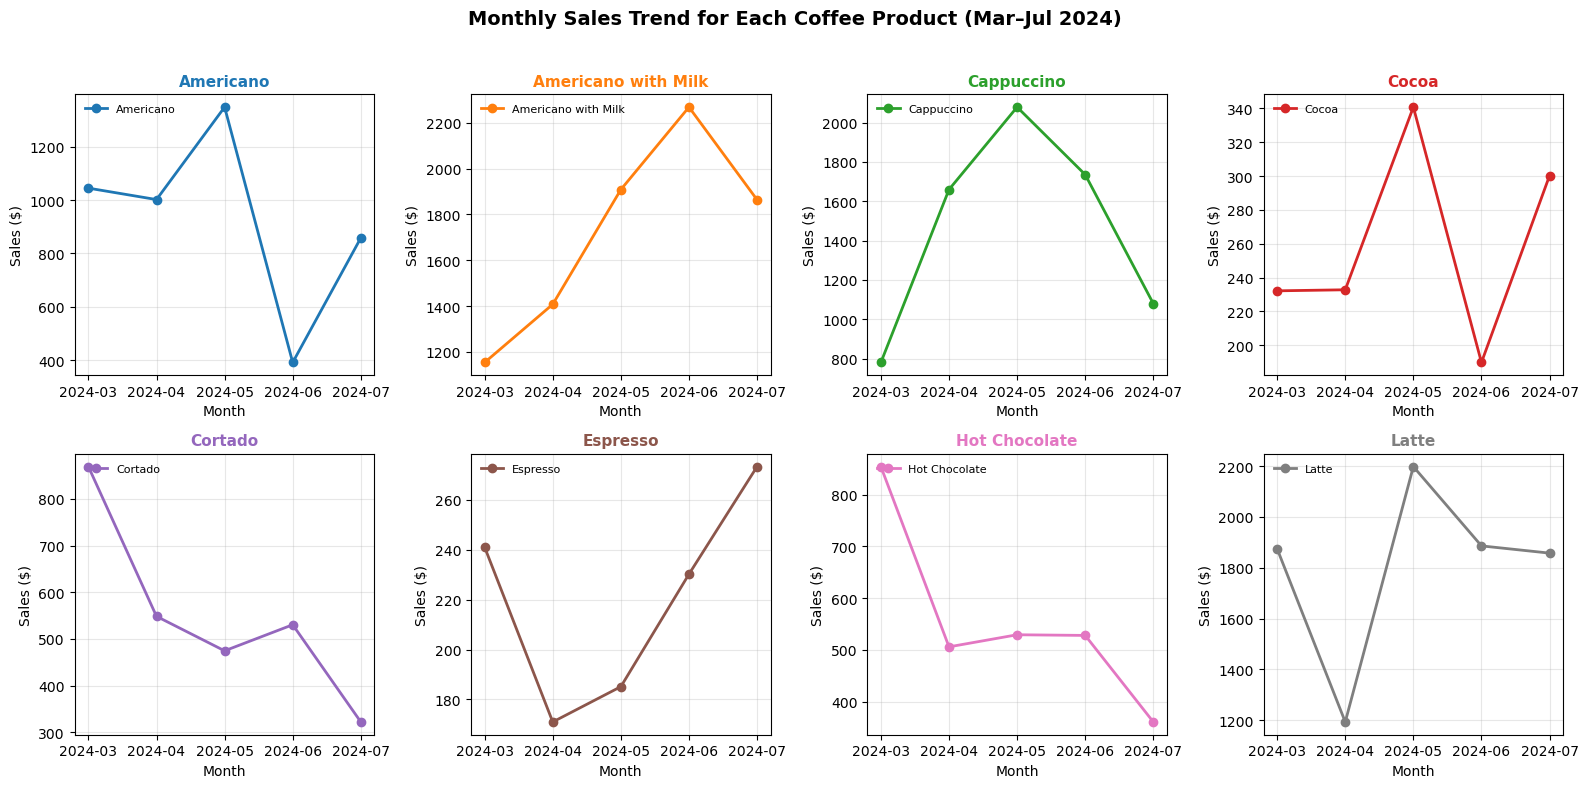

In [29]:
# Line Plots — Monthly Sales (2×4 Grid)
rows, cols = 2, 4
fig, axes = plt.subplots(rows, cols, figsize=(16,8))
axes = axes.flatten()

for i, product in enumerate(products):
    prod_data = monthly_sales[monthly_sales['product'] == product]
    color = colors[i % len(colors)]  # Assign color for each product
    
    axes[i].plot(
        prod_data['year_month'].astype(str),
        prod_data['amount'],
        marker='o',
        linewidth=2,
        color=color,
        label=product
    )
    
    axes[i].set_title(product, fontsize=11, fontweight='bold', color=color)
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('Sales ($)')
    axes[i].grid(alpha=0.3)
    axes[i].legend(loc='upper left', fontsize=8, frameon=False)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Monthly Sales Trend for Each Coffee Product (Mar–Jul 2024)', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

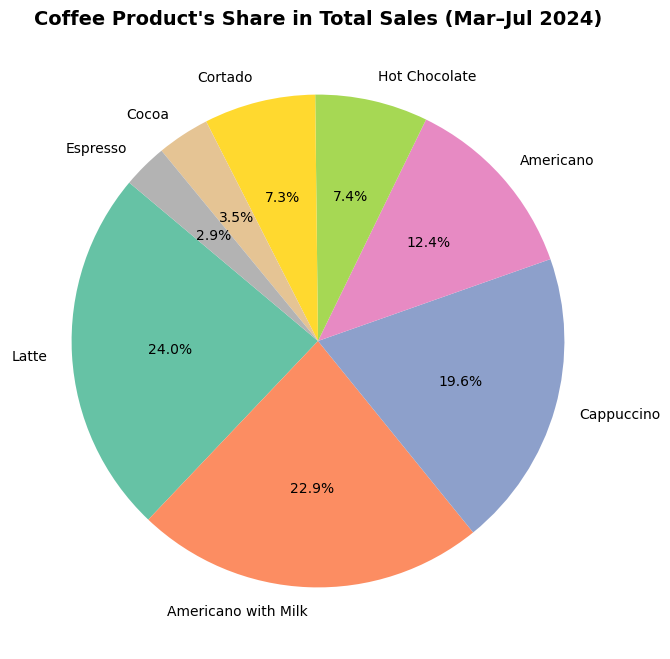

In [30]:
plt.figure(figsize=(8,8))
plt.pie(
    total_sales['amount'],
    labels=total_sales['product'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('Set2', n_colors=len(total_sales))
)
plt.title("Coffee Product's Share in Total Sales (Mar–Jul 2024)", fontsize=14, fontweight='bold')
plt.show()

#### Summary Insights

In [31]:
# Group by payment type and sum the total money spent
payment_summary = df.groupby('cash_type', as_index=False)['amount'].sum()
payment_summary.head()

,cash_type,amount
0,card,34322.88
1,cash,3186.00


C:\Users\dell\AppData\Local\Temp\ipykernel_11148\2060874921.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=payment_summary, x='cash_type', y='amount', palette='coolwarm')


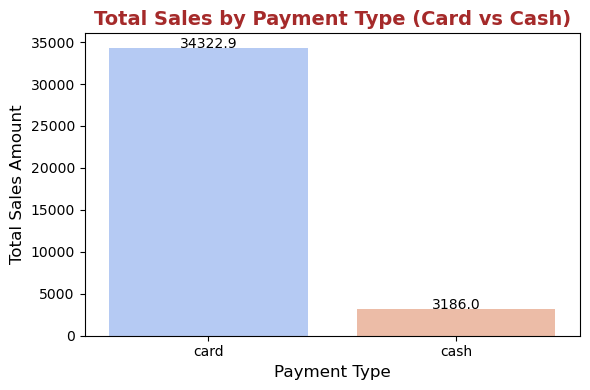

In [32]:
plt.figure(figsize=(6,4))
sns.barplot(data=payment_summary, x='cash_type', y='amount', palette='coolwarm')
plt.title('Total Sales by Payment Type (Card vs Cash)', fontsize=14, fontweight='bold', color='brown')
plt.xlabel('Payment Type', fontsize=12)
plt.ylabel('Total Sales Amount', fontsize=12)
for i, row in payment_summary.iterrows():
    plt.text(i, row['amount'] + 2, f"{row['amount']:.1f}", ha='center', fontsize=10, color='black')
plt.tight_layout()
plt.show()

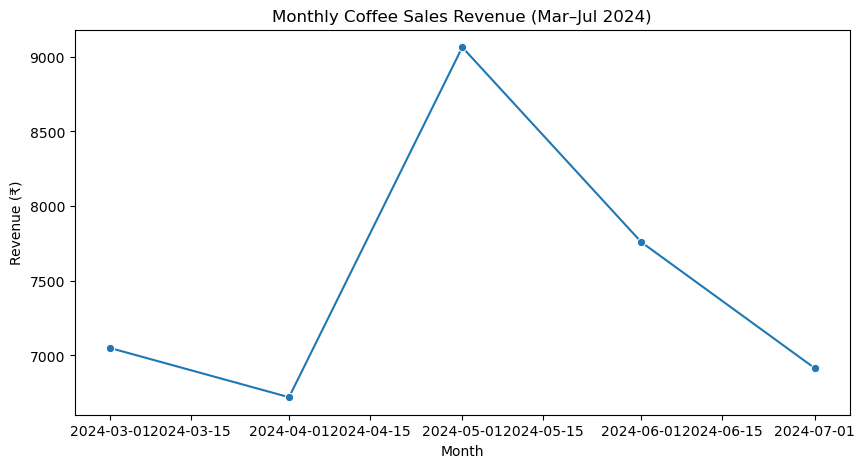

In [33]:
# Monthly Revenue Trend
monthly_sales = df.groupby(df['datetime'].dt.to_period('M'))['amount'].sum().reset_index()
monthly_sales['datetime'] = monthly_sales['datetime'].dt.to_timestamp()

plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_sales, x='datetime', y='amount', marker='o')
plt.title("Monthly Coffee Sales Revenue (Mar–Jul 2024)")
plt.xlabel("Month")
plt.ylabel("Revenue (₹)")
plt.show()

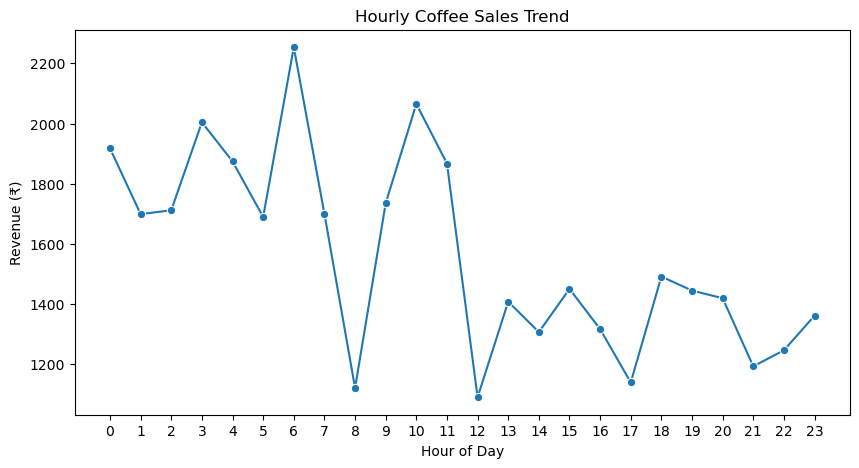

In [34]:
# Peak Hour Analysis
hourly_sales = df.groupby('hour')['amount'].sum()

plt.figure(figsize=(10,5))
sns.lineplot(x=hourly_sales.index, y=hourly_sales.values, marker='o')
plt.title("Hourly Coffee Sales Trend")
plt.xlabel("Hour of Day")
plt.ylabel("Revenue (₹)")
plt.xticks(range(0,24))
plt.show()

In [35]:
print("🔹 Insights Summary 🔹")
print(f"• Total Revenue: ₹{df['amount'].sum():.2f}")
print(f"• Average Sale per Transaction: ₹{df['amount'].mean():.2f}")
print(f"• Best-Selling Coffee: {coffee_sales.idxmax()} (₹{coffee_sales.max():.2f})")
print(f"• Peak Sales Hour: {hourly_sales.idxmax()} hrs")
print(f"• Month with Highest Revenue: {monthly_sales.loc[monthly_sales['amount'].idxmax(), 'datetime'].strftime('%B %Y')}")

🔹 Insights Summary 🔹
• Total Revenue: ₹37508.88
• Average Sale per Transaction: ₹33.11


NameError: name 'coffee_sales' is not defined